In [1]:
import os
import cv2
import yaml
import random
import numpy as np
from PIL import Image

import torch
from ultralytics import YOLO, YOLOWorld
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.predict import get_prediction
from matplotlib import pyplot as plt

In [2]:
import utils

import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\citak\\Desktop\\SensorFusion\\color_image_based_object_detection\\utils.py'>

## Dataset Reading

In [3]:
###############################
## Document Path Definition ##
###############################

kitti_main_path = r'C:\KITTI'

kitti_point_clouds_path = os.path.join(kitti_main_path, 'point_clouds')
kitti_point_clouds_training_path = os.path.join(kitti_point_clouds_path, 'training')
kitti_point_clouds_testing_path = os.path.join(kitti_point_clouds_path, 'testing')

kitti_images_path = os.path.join(kitti_main_path, 'left_color_images')
kitti_images_training_path = os.path.join(kitti_images_path, 'training')
kitti_images_testing_path = os.path.join(kitti_images_path, 'testing')

kitti_labels_path = os.path.join(kitti_main_path, 'training_labels')
kitti_labelss_training_path = os.path.join(kitti_labels_path, 'training')

kitti_calibration_path = os.path.join(kitti_main_path, 'data_object_calib')
kitti_calibration_training_path = os.path.join(kitti_calibration_path, 'training')

In [4]:
kitti_images_training = os.listdir(kitti_images_training_path)
kitti_images_training = [os.path.join(kitti_images_training_path, elem) for elem in kitti_images_training]

kitti_images_testing = os.listdir(kitti_images_testing_path)
kitti_images_testing = [os.path.join(kitti_images_testing_path, elem) for elem in kitti_images_testing]

print("# of training and testing images: {} / {}".format(len(kitti_images_training), len(kitti_images_testing)))

# of training and testing images: 7481 / 7518


In [5]:
kitti_training_labels = os.listdir(kitti_labelss_training_path)
kitti_training_labels_paths = [os.path.join(kitti_labelss_training_path, label_file) for label_file in kitti_training_labels]


print("# of training files: {}".format(len(kitti_training_labels)))

example_label_file = utils.parse_label_file(kitti_training_labels_paths[0])
print(example_label_file)

# of training files: 7481
[{'Type': 'Pedestrian', 'Truncated': 0.0, 'Occluded': 0, 'Alpha': -0.2, 'BBox_xmin': 712.4, 'BBox_ymin': 143.0, 'BBox_xmax': 810.73, 'BBox_ymax': 307.92, 'Dimensions_height': 1.89, 'Dimensions_width': 0.48, 'Dimensions_length': 1.2, 'Location_x': 1.84, 'Location_y': 1.47, 'Location_z': 8.41, 'RotationY': 0.01}]


In [6]:
kitti_training_calibrations = os.listdir(kitti_calibration_training_path)
kitti_training_calibrations_paths = [os.path.join(kitti_calibration_training_path, calib_file) for calib_file in kitti_training_calibrations]


print("# of training calibration files: {}".format(len(kitti_training_calibrations_paths)))


print(kitti_training_calibrations_paths[0])

example_calib_file = utils.parse_calib_file(kitti_training_calibrations_paths[0])
print(example_calib_file)

# of training calibration files: 7481
C:\KITTI\data_object_calib\training\000000.txt
{'P0': array([[     707.05,           0,      604.08,           0],
       [          0,      707.05,      180.51,           0],
       [          0,           0,           1,           0]], dtype=float32), 'P1': array([[     707.05,           0,      604.08,     -379.78],
       [          0,      707.05,      180.51,           0],
       [          0,           0,           1,           0]], dtype=float32), 'P2': array([[     707.05,           0,      604.08,      45.758],
       [          0,      707.05,      180.51,    -0.34542],
       [          0,           0,           1,    0.004981]], dtype=float32), 'P3': array([[     707.05,           0,      604.08,     -334.11],
       [          0,      707.05,      180.51,      2.3307],
       [          0,           0,           1,   0.0032012]], dtype=float32), 'R0': array([[    0.99991,    0.010093,  -0.0085119],
       [  -0.010127,     0.99994,  -

## Open World Detection Model Initialization

In [7]:
# Load YOLOOpenWorld model (pre-trained on COCO dataset)
yoloWorld_model = YOLOWorld("yolov8x-worldv2.pt")

In [8]:
# Define class names to filter
target_classes = ["car", "van", "truck", "pedestrian", "person_sitting", "cyclist", "tram"]  
class_map = {idx:class_name for idx, class_name in enumerate(target_classes)}

print(target_classes)

## set the interested classes there
yoloWorld_model.set_classes(target_classes)

['car', 'van', 'truck', 'pedestrian', 'person_sitting', 'cyclist', 'tram']


c:\Users\citak\anaconda3\envs\sensorFusion\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [9]:
results = yoloWorld_model.predict(r"C:\KITTI\Yolo_FineTune\val\images\005993.png")
print(results)


image 1/1 C:\KITTI\Yolo_FineTune\val\images\005993.png: 224x640 2 cars, 91.2ms
Speed: 2.0ms preprocess, 91.2ms inference, 7.0ms postprocess per image at shape (1, 3, 224, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'car', 1: 'van', 2: 'truck', 3: 'pedestrian', 4: 'person_sitting', 5: 'cyclist', 6: 'tram'}
obb: None
orig_img: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 19,  17,   8],
        [ 17,  18,  12],
        [ 18,  19,  17]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 17,  18,  19],
        [ 16,  20,  18],
        [ 15,  21,  16]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 12,  19,  17],
        [ 12,  22,  16],
        [ 12,  23,  16]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
      

## A sample analysis

The Calib. Data
{'P0': array([[     707.05,           0,      604.08,           0],
       [          0,      707.05,      180.51,           0],
       [          0,           0,           1,           0]], dtype=float32), 'P1': array([[     707.05,           0,      604.08,     -379.78],
       [          0,      707.05,      180.51,           0],
       [          0,           0,           1,           0]], dtype=float32), 'P2': array([[     707.05,           0,      604.08,      45.758],
       [          0,      707.05,      180.51,    -0.34542],
       [          0,           0,           1,    0.004981]], dtype=float32), 'P3': array([[     707.05,           0,      604.08,     -334.11],
       [          0,      707.05,      180.51,      2.3307],
       [          0,           0,           1,   0.0032012]], dtype=float32), 'R0': array([[    0.99991,    0.010093,  -0.0085119],
       [  -0.010127,     0.99994,  -0.0040377],
       [  0.0084707,   0.0041235,     0.99996]], dtype=fl

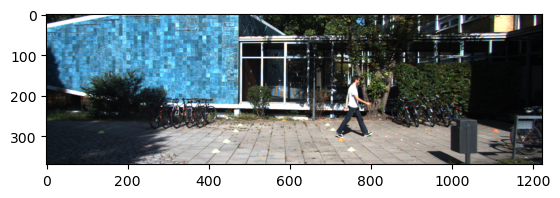

In [60]:
analysis_file_index = 0

## 1. Load Data

################
#### Calib Label
################
sample_calib = utils.parse_calib_file(kitti_training_calibrations_paths[analysis_file_index])
print('The Calib. Data')
print(sample_calib)


###############
#### G.T. Label
###############
sample_label = utils.parse_label_file(kitti_training_labels_paths[analysis_file_index])
print('The G.T. Objects and Their Meta Data')
print(sample_label)

###############
#### Image Side
###############

sample_image_path = kitti_images_training[analysis_file_index]
print("Sample Image Path: {}\n".format(sample_image_path))
sample_image = cv2.imread(sample_image_path) # bgr format
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

plt.imshow(sample_image_rgb);


0: 224x640 1 person_sitting, 183.0ms
Speed: 2.0ms preprocess, 183.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)
[{'bounding_box': [712.9672241210938, 151.35850524902344, 805.6149291992188, 304.6961364746094], 'object_name': 'person_sitting', 'confidence': 0.6997523307800293}]
[{'bounding_box': [712.9672241210938, 151.35850524902344, 805.6149291992188, 304.6961364746094], 'object_name': 'person_sitting', 'confidence': 0.6997523307800293}]


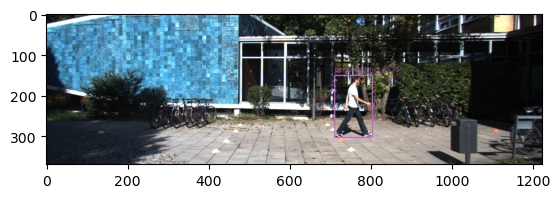

In [61]:
## 2. Perform detection and detection list arrangement
det_boxes, det_class_ids, det_scores = utils.perform_detection_and_nms(yoloWorld_model, sample_image, det_conf= 0.35, nms_thresh= 0.25)

if det_boxes.ndim == 1:
    det_boxes = np.reshape(det_boxes, (1,4))
    det_class_ids = [det_class_ids]
    det_scores = [det_scores]
else:
    pass


## create a list from detection boxes, class ids, und scores
pred_detections = []
for box, class_id, score in zip(det_boxes, det_class_ids, det_scores):
    class_name = class_map[class_id]
    pred_detections.append({
                        "bounding_box": box.tolist(),
                        "object_name": class_name,
                        "confidence": float(score)
                    })
    
print(pred_detections)

# Display results
pred_draw_image = utils.draw_detection_output(sample_image_rgb, pred_detections)
cv2.imwrite('Pred_draw_image.png', pred_draw_image[:,:,::-1])
plt.imshow(pred_draw_image);
print(pred_detections)

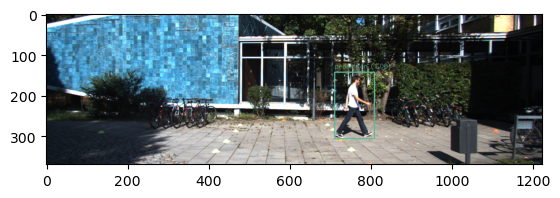

In [62]:
## 3. Get the G.T. coordinatges
gt_detections = []   
    
for gt_object in sample_label:
    class_name = gt_object['Type'].lower()

    if class_name == 'dontcare':
        continue

    x_min, y_min, x_max, y_max= gt_object["BBox_xmin"], gt_object["BBox_ymin"], gt_object["BBox_xmax"], gt_object["BBox_ymax"]
    gt_detections.append({
                        "bounding_box": [x_min, y_min, x_max, y_max],
                        "object_name": class_name.lower(),
                        "confidence": float(1.0)
                    })

# Display results
gt_draw_image = utils.draw_detection_output(sample_image_rgb, gt_detections)
cv2.imwrite('GT_draw_image.png', gt_draw_image[:,:,::-1])
plt.imshow(gt_draw_image);

In [63]:
## 4. Evaluate the predicted detections with G.T. detections
print("# predicted boxes: {}".format(len(pred_detections)))
print("# G.T. boxes: {}".format(len(gt_detections)))
tp, fp, fn, tp_boxes, fp_boxes, fn_boxes = utils.evaluate_detections(pred_detections, gt_detections, iou_threshold=0.40)
pred_precision, pred_recall = utils.calculate_precision_recall(tp, fp, fn)
print(f"TP: {tp}, FP: {fp}, FN: {fn}")
print(f"Precision: {pred_precision}, Recall: {pred_recall}")

# predicted boxes: 1
# G.T. boxes: 1
TP: 0, FP: 1, FN: 1
Precision: 0.0, Recall: 0.0


### Test the G.T. sample with fine-tuned Yolo v8

In [15]:
## 5. Load the fine-tuned yolo8 model
fine_tuned_model = YOLO("yolo_runs/fine_tuning/weights/best.pt")

In [16]:
## open yaml file to match class ids with their names
class_name_2_ids = dict()

with open(r"C:\KITTI\Yolo_FineTune\data.yaml") as stream:
    try:
        tuned_model_class_names = yaml.safe_load(stream)['names']
        for idx, class_name in enumerate(tuned_model_class_names):
            class_name_2_ids[class_name] = idx
    except yaml.YAMLError as exc:
        print(exc)

ids_2_class_name = {value: key for key, value in class_name_2_ids.items()}

print(class_name_2_ids)
print(ids_2_class_name)

{'person_sitting': 0, 'pedestrian': 1, 'cyclist': 2, 'truck': 3, 'tram': 4, 'car': 5, 'van': 6}
{0: 'person_sitting', 1: 'pedestrian', 2: 'cyclist', 3: 'truck', 4: 'tram', 5: 'car', 6: 'van'}


In [17]:
## 6. Make prediction with the fine-tuned model
tuned_model_det_boxes, tuned_model_det_class_ids, tuned_model_det_scores = utils.perform_detection_and_nms(fine_tuned_model, sample_image, det_conf= 0.10, nms_thresh= 0.50)


0: 224x640 2 pedestrians, 1 cyclist, 9 cars, 90.1ms
Speed: 0.0ms preprocess, 90.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)


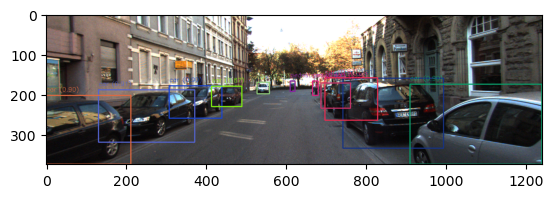

In [18]:
## 7. Create a list from detection boxes, class ids, und scores
tuned_model_pred_detections = []
for box, class_id, score in zip(tuned_model_det_boxes, tuned_model_det_class_ids, tuned_model_det_scores):
    class_name = ids_2_class_name[class_id].lower()
    tuned_model_pred_detections.append({
                        "bounding_box": box.tolist(),
                        "object_name": class_name,
                        "confidence": float(score)
                    })
    
# Display results
tuned_model_pred_draw_image = utils.draw_detection_output(sample_image_rgb, tuned_model_pred_detections)
cv2.imwrite('tuned_model_draw_image.png', tuned_model_pred_draw_image[:,:,::-1])
plt.imshow(tuned_model_pred_draw_image);

In [19]:
print("# predicted boxes: {}".format(len(tuned_model_pred_detections)))
print("# G.T. boxes: {}".format(len(gt_detections)))
tp, fp, fn, tp_boxes, fp_boxes, fn_boxes = utils.evaluate_detections(tuned_model_pred_detections, gt_detections, iou_threshold=0.40)
tuned_model_precision, tuned_model_recall = utils.calculate_precision_recall(tp, fp, fn)
print(f"TP: {tp}, FP: {fp}, FN: {fn}")
print(f"Precision: {tuned_model_precision}, Recall: {tuned_model_recall}")

# predicted boxes: 11
# G.T. boxes: 12
TP: 11, FP: 0, FN: 1
Precision: 1.0, Recall: 0.9166666666666666


### Make Tuned Model inference with SAHI

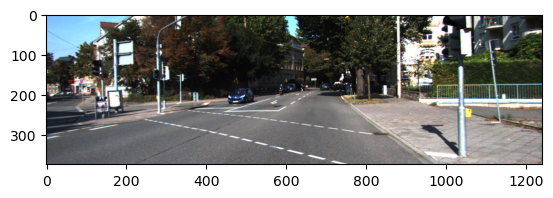

In [20]:
## 8. SAHI Sample Image
SAHI_sample_image_path = r'C:\KITTI\Yolo_FineTune\val\images\006946.png'
SAHI_sample_image = cv2.imread(SAHI_sample_image_path)
SAHI_sample_image_rgb = cv2.cvtColor(SAHI_sample_image, cv2.COLOR_BGR2RGB)

plt.imshow(SAHI_sample_image_rgb)

In [21]:
# Initialize the model 
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path="yolo_runs/fine_tuning/weights/best.pt",
    confidence_threshold=0.30,
    device="cuda:0",  # or 'cuda:0'
)

In [22]:
# 9. Perform inference with slicing
result = get_sliced_prediction(
    SAHI_sample_image_rgb,
    detection_model,
    slice_height=345,  # Height of each slice
    slice_width=640,   # Width of each slice
    overlap_height_ratio=0.2,  # Overlap between slices
    overlap_width_ratio=0.2,   # Overlap between slices
)

print(result.to_coco_predictions())


Performing prediction on 6 slices.
[{'image_id': None, 'bbox': [580.3746795654297, 173.2801513671875, 15.574844360351562, 30.90716552734375], 'score': 0.40044665336608887, 'category_id': 2, 'category_name': 'cyclist', 'segmentation': [], 'iscrowd': 0, 'area': 481}, {'image_id': None, 'bbox': [452.459716796875, 180.72972106933594, 73.67509365081787, 47.01177978515625], 'score': 0.9078516960144043, 'category_id': 5, 'category_name': 'car', 'segmentation': [], 'iscrowd': 0, 'area': 3463}, {'image_id': None, 'bbox': [684.6712036132812, 171.59658813476562, 28.93487548828125, 20.889297485351562], 'score': 0.8160659670829773, 'category_id': 5, 'category_name': 'car', 'segmentation': [], 'iscrowd': 0, 'area': 604}, {'image_id': None, 'bbox': [582.8839416503906, 173.69512939453125, 34.44559955596924, 24.717803955078125], 'score': 0.6659420132637024, 'category_id': 5, 'category_name': 'car', 'segmentation': [], 'iscrowd': 0, 'area': 851}, {'image_id': None, 'bbox': [597.1756896972656, 172.490325

In [23]:
result.export_visuals(export_dir=".",file_name="sahi_draw_image")


0: 224x640 1 cyclist, 1 car, 23.8ms
Speed: 1.0ms preprocess, 23.8ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)


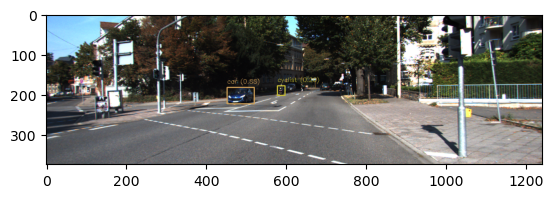

In [24]:
## 10. How about the scores WITHOUT SAHI?
tuned_model_det_boxes, tuned_model_det_class_ids, tuned_model_det_scores = utils.perform_detection_and_nms(fine_tuned_model, SAHI_sample_image_rgb, det_conf= 0.10, nms_thresh= 0.50)

## create a list from detection boxes, class ids, und scores
tuned_model_pred_detections = []
for box, class_id, score in zip(tuned_model_det_boxes, tuned_model_det_class_ids, tuned_model_det_scores):
    class_name = ids_2_class_name[class_id].lower()
    tuned_model_pred_detections.append({
                        "bounding_box": box.tolist(),
                        "object_name": class_name,
                        "confidence": float(score)
                    })
    
# Display results
tuned_model_pred_draw_image = utils.draw_detection_output(SAHI_sample_image_rgb, tuned_model_pred_detections)
plt.imshow(tuned_model_pred_draw_image);